In [3]:
using Images, PyPlot
include("Common.jl")

Main.Common

In [4]:
#---------------------------------------------------------
# Loads grayscale and color image given PNG filename.
#
# INPUTS:
#   filename     given PNG image file
#
# OUTPUTS:
#   gray         single precision grayscale image
#   rgb          single precision color image
#
#---------------------------------------------------------
function loadimage(filename)
    #load two versions of the image
    rgb = imread(filename)
    gray = Common.rgb2gray(rgb)
  return gray::Array{Float64,2}, rgb::Array{Float32,3}  ##TALK ABOUT IT WAS 64 instead 32 
end


loadimage (generic function with 1 method)

In [5]:
#---------------------------------------------------------
# Computes entries of Hessian matrix.
#
# INPUTS:
#   img             grayscale color image
#   sigma           std for presmoothing image
#   fsize           filter size for smoothing
#
# OUTPUTS:
#   I_xx       second derivative in x-direction
#   I_yy       second derivative in y-direction
#   I_xy       derivative in x- and y-direction
#
#---------------------------------------------------------
function computehessian(img::Array{Float64,2},sigma::Float64,fsize::Int)
  # Init gauss filter
  g  = Common.gauss2d(sigma, [fsize, fsize])
  g2 = Common.gauss2d(1.6*sigma, [fsize, fsize])
  d = [0 -0.5 0 ; 0 0 0; 0 0.5 0]'
  sm = imfilter(img, centered(g), "replicate")
  # Filter with gauss
  dx = imfilter(sm, centered(d), "replicate")
  dy = imfilter(sm,d', "replicate")

  I_xx = imfilter(dx.^2,centered(g2), "replicate")
  I_yy = imfilter(dy.^2,centered(g2), "replicate")
  I_xy = imfilter(dx.*dy, centered(g2), "replicate")
  return I_xx::Array{Float64,2},I_yy::Array{Float64,2},I_xy::Array{Float64,2}
end

computehessian (generic function with 1 method)

In [6]:
#---------------------------------------------------------
# Computes function values of Hessian criterion.
#
# INPUTS:
#   I_xx       second derivative in x-direction
#   I_yy       second derivative in y-direction
#   I_xy       derivative in x- and y-direction
#   sigma      std that was used for smoothing image
#
# OUTPUTS:
#   criterion  function score
#
#---------------------------------------------------------
function computecriterion(I_xx::Array{Float64,2},I_yy::Array{Float64,2},I_xy::Array{Float64,2}, sigma::Float64)
    
    d = I_xx.*I_yy - I_xy.^2
    t = I_xx+I_yy
    criterion = sigma^4 * (d - 0.06*t.^2)
  return criterion::Array{Float64,2}
end

computecriterion (generic function with 1 method)

In [10]:
#---------------------------------------------------------
# Non-maximum suppression of criterion function values.
#   Extracts local maxima within a 5x5 window and
#   allows multiple points with equal values within the same window.
#   Discards interest points in a 5 pixel boundary.
#   Applies thresholding with the given threshold.
#
# INPUTS:
#   criterion  function score
#   thresh     param for thresholding
#
# OUTPUTS:
#   rows        row positions of kept interest points
#   columns     column positions of kept interest points
#
#---------------------------------------------------------
function nonmaxsupp(criterion::Array{Float64,2}, thresh::Float64)
   
    max = criterion .- Common.nlfilter(criterion, maximum, 5, 5) .== 0.0

    max[1:5,:] .= false
    max[end-4:end,:] .= false
    max[:,1:5] .= false
    max[:,end-4:end] .= false

    m_thresh = criterion .> thresh
    indices = findall(max .& m_thresh)
    
    rows = [index[1] for index in indices]
    columns = [index[2] for index in indices]
    
  return rows::Array{Int,1},columns::Array{Int,1}
end

nonmaxsupp (generic function with 1 method)

In [11]:
#---------------------------------------------------------
# Problem 1: Interest point detector
#---------------------------------------------------------
function problem1()
  # parameters
  sigma = 4.5              # std for presmoothing image
  fsize = 2               # filter size for smoothing
  threshold = 0.001           # Corner criterion threshold

  # Load both colored and grayscale image from PNG file
  gray,rgb = loadimage("a3p1.png")

  # Compute the three components of the Hessian matrix
  I_xx,I_yy,I_xy = computehessian(gray,sigma,fsize)

  # Compute Hessian based corner criterion
  criterion = computecriterion(I_xx,I_yy,I_xy,sigma)

  # Display Hessian criterion image
  figure()
  imshow(criterion,"jet",interpolation="none")
  axis("off")
  title("Determinant of Hessian")
  gcf()

  # Threshold corner criterion
  mask = criterion .> threshold
  rows, columns = Common.findnonzero(mask)
  figure()
  imshow(rgb)
  plot(columns.-1,rows.-1,"xy",linewidth=8)
  axis("off")
  title("Hessian interest points without non-maximum suppression")
  gcf()

  # Apply non-maximum suppression
  rows,columns = nonmaxsupp(criterion,threshold)

  # Display interest points on top of color image
  figure()
  imshow(rgb)
  plot(columns.-1,rows.-1,"xy",linewidth=8)
  axis("off")
  title("Hessian interest points after non-maximum suppression")
  gcf()
  return nothing
end


problem1 (generic function with 1 method)

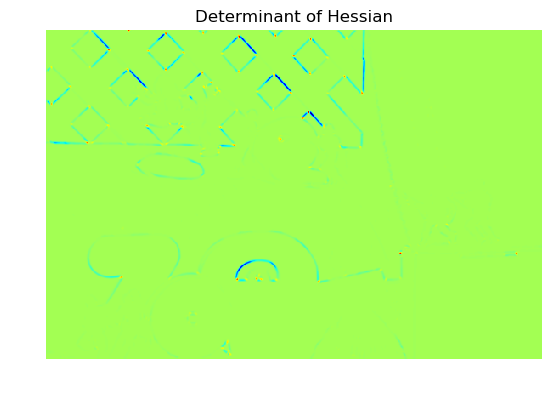

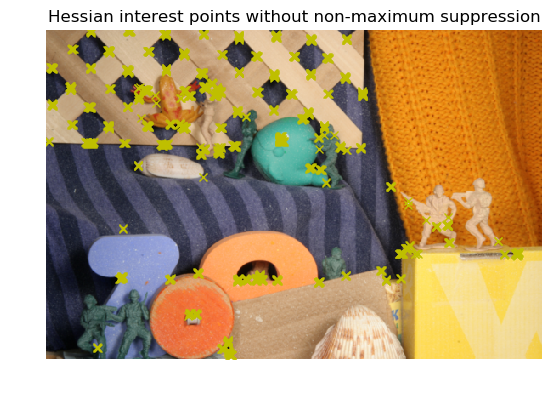

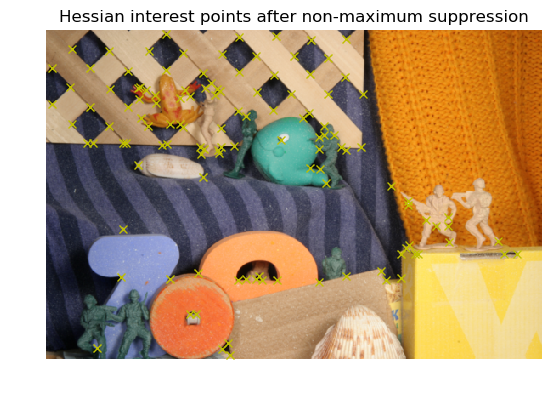

In [12]:
problem1()